**Original code**: [Babak Khavari](https://github.com/babakkhavari)<br>
**Conceptualization & Methodological review** : [Babak Khavari](https://github.com/babakkhavari)<br>
**Updates, Modifications**: [Babak Khavari](https://github.com/babakkhavari)<br>

# Functions

The following noteboook includes the packages and functions used in the main-file to produce. 

**Note:** Changing this file might break the clustering algorithm

## Packages needed

In [14]:
import geopandas as gpd
import os
import fiona
import rasterio.mask
from rasterio.fill import fillnodata
from rasterstats import zonal_stats
import numpy as np
import tkinter as tk
from tkinter import filedialog, messagebox
import rasterio
import json
import pandas as pd
from osgeo import gdal, ogr, osr
import warnings
import alphashape
from shapely.geometry import Polygon, Point
warnings.filterwarnings('ignore')

root = tk.Tk()
root.withdraw()
root.attributes("-topmost", True)

''

## Clip raster

In [2]:
def clipRasterByExtent(output, raster, polygon, nodata):
    """
    Clipping a raster to the extent of a polygon layer

    Parameters
    ----------
    arg1 : output
        The path and file name of the clipped raster
    arg2 : raster
        Raster dataset to clip
    arg3 : polygon
        Polygon layer to clip by
    arg4 : nodata
        Value to be used as nodata in the clipped raster

    Returns
    ----------
    Two clipped raster layers. The layers are the same, but one of them is compatible with rasterio 
    while the other one is compatible with GDAL  
    """
    
    bbox = polygon.total_bounds
    bbox2 = [bbox[0], bbox[3], bbox[2], bbox[1]]
    clipped = gdal.Translate(output, raster, projWin = bbox2, noData = nodata)
    rasterrasterio = rasterio.open(output)
    raster=gdal.Open(output)
    output = None
    return rasterrasterio, raster

## Reclassify raster

In [3]:
def reclassifyRasters(raster, threshold):    
    """
    Reclassify the rasters, setting the cells below the threshold of each raster dataset to 0.

    Parameters
    ----------
    arg1 : raster
        Raster dataset to reclassify. This is the clipped rasters from the previous cell
    arg2 : threshold 
        Threshold used in order to remove everything below the threshold to zero.  

    Returns
    ----------
    A reclassified raster layer without values under the threshold  
    """
    
    driver = gdal.GetDriverByName("MEM")
    band = raster.GetRasterBand(1)
    lista = band.ReadAsArray()
    
    lista[np.where(threshold >= lista)] = 0
    lista[np.where((threshold < lista) & (lista < 99999))] = 1

    raster2 = driver.Create('', raster.RasterXSize , raster.RasterYSize , 1, gdal.GDT_Float32)
    raster2.GetRasterBand(1).WriteArray(lista)

    proj = raster.GetProjection()
    georef = raster.GetGeoTransform()
    raster2.SetProjection(proj)
    raster2.SetGeoTransform(georef)
    raster2.FlushCache()
    
    return raster2

## Resample raster

In [4]:
def resampleRaster(raster, factor):
    """
    Resample rasters by a specified factor 

    Parameters
    ----------
    arg1 : raster
        Raster dataset to resample.
    arg2 : factor 
        Factor used for the resampling.   

    Returns
    ----------
    Resampled raster layer with the each side of the pixels being a specified factor larger than the original pixel 
    """
    
    gt =raster.GetGeoTransform()
    xRes = factor*gt[1]
    yRes = factor*gt[1]
    kwargs1 = {'noData':'0'}
    resamp1 = gdal.Translate('',raster, format ='MEM', **kwargs1)
    kwargs2 = {'xRes': xRes, 'yRes': yRes, 'resampleAlg': "mode"}    
    resampled = gdal.Translate('',resamp1, format ='MEM', noData = 0, **kwargs2)
    return resampled

## Rasterize Polygon

In [5]:
def rasterize(vector, vector_path, raster, output):
    """
    Converts vector layer to raster. 

    Parameters
    ----------
    arg1 : vector
        Vector layer to convert to raster
    arg2 : vector_path 
        The path of the vector layer that you is to be converted
    arg3 : raster
        Raster to use as template for the rasterization
    arg4 : output
        Path to the output raster

    Returns
    ----------
    Rasterized vector layer
    """
    
    vector["id"] = np.arange(len(vector))+1
    vector.to_file(vector_path)

    geo_transform = raster.GetGeoTransform()
    x_min = geo_transform[0]
    y_max = geo_transform[3]
    x_max = x_min + geo_transform[1] * raster.RasterXSize
    y_min = y_max + geo_transform[5] * raster.RasterYSize
    x_res = raster.RasterXSize
    y_res = raster.RasterYSize
    mb_v = ogr.Open(vector_path)
    mb_l = mb_v.GetLayer()
    pixel_width = geo_transform[1]
    target_ds = gdal.GetDriverByName('GTiff').Create(output, x_res, y_res, 1, gdal.GDT_Byte)
    target_ds.SetGeoTransform((x_min, pixel_width, 0, y_max, 0, -pixel_width))
    target_dsSRS = osr.SpatialReference()
    target_dsSRS.ImportFromEPSG(4326)
    target_ds.SetProjection(target_dsSRS.ExportToWkt())
    band = target_ds.GetRasterBand(1)
    NoData_value = -999999
    band.SetNoDataValue(NoData_value)
    band.FlushCache()
    gdal.RasterizeLayer(target_ds, [1], mb_l, options=["ATTRIBUTE=id"])
    target_ds = None

## Rastercalculator

In [6]:
def rasterMultiplication(rstpth1,rstpth2, output, filetype = gdal.GDT_Float32):
    """
    Multiplies raster layers. 

    Parameters
    ----------
    arg1 : rstpth1
        Path of the first raster
    arg2 : rstpth2 
        Path of the second raster
    arg3 : output
        Path to the output raster
    arg4 : filetype
        Raster filetype    

    Returns
    ----------
    Rasterproduct of two rasters
    """
    
    rst1 = gdal.Open(rstpth1)
    band_data1 = rst1.GetRasterBand(1)
    a = band_data1.ReadAsArray()

    rst2 = gdal.Open(rstpth2)
    band_data2 = rst2.GetRasterBand(1)
    b = band_data2.ReadAsArray()
    
    f = b * a
        
    ref = gdal.Open(rstpth1)
    band = ref.GetRasterBand(1)
    proj = ref.GetProjection()
    geotransform = ref.GetGeoTransform()
    xsize = band.XSize
    ysize = band.YSize
    
    driver = gdal.GetDriverByName('GTiff') 
    out = driver.Create(output, xsize, ysize, 1, filetype)
    out.GetRasterBand(1).WriteArray(f) 
    
    out.SetProjection(proj)
    out.SetGeoTransform(geotransform)
    out.FlushCache()
    out = None
    x = gdal.Open(output)
    
    return x

## Urban/rural split

In [7]:
def calibrateUrban(clusters, urban_current, workspace):
    """
    Calibrate urban population. Classifies clusters to either urban(2), peri-urban(1) or rural(0). 

    Parameters
    ----------
    arg1 : clusters
        Population clusters with population column
    arg2 : urban_current
        Urban ration defined by the user
    arg3 : workspace
        Output folder in which the clusters as saved after the urban classification

    Returns
    ----------
    Population clusters with an ubran-rural classifcation column 
    """
    
    urban_modelled = 2
    factor = 1
    pop_tot = clusters["Population"].sum()
    i = 0
    while abs(urban_modelled - urban_current) > 0.01:
        clusters["IsUrban"] = 0
        clusters.loc[(clusters["Population"] > 5000 * factor) & (
            clusters["Population"] / clusters["Area"] > 300 * factor), "IsUrban"] = 1
        clusters.loc[(clusters["Population"] > 50000 * factor) & (
            clusters["Population"] / clusters["Area"] > 1500 * factor), "IsUrban"] = 2
        pop_urb = clusters.loc[clusters["IsUrban"] > 1, "Population"].sum()
        
        urban_modelled = pop_urb / pop_tot
        
        if urban_modelled > urban_current:
            factor *= 1.1
        else:
            factor *= 0.9
        i=i+1
        if i > 500:
            break
            print(i)
    
    clusters.to_file(workspace + r"/clusters.shp") 
    
    print("Modelled urban ratio is " + str(round(urban_modelled, 3)) + "% in comparision to the actual ratio of " + str(urban_current) + "% after " + str(i) + " iterations.")

## Convert raster to polygon

In [8]:
def toPolygon(Raster, opt, output):
    """
    Polygonizes a raster layer. 

    Parameters
    ----------
    arg1 : Raster
        Raster to convert to polygon
    arg2 : opt
        Options that will add an buffer to the NTL polygon
    arg3 : crs
        Path to the polygon output
        
    Returns
    ----------
    Polygonized raster
    """ 
    
    if type(Raster) == str:
        Raster = gdal.Open(Raster)
    
    band = Raster.GetRasterBand(1)
    bandArray = band.ReadAsArray()
    
    outShapefile = output
    
    driver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outShapefile+".shp"):
        driver.DeleteDataSource(outShapefile+".shp")
    outDatasource = driver.CreateDataSource(outShapefile+ ".shp")
    
    spat_ref = osr.SpatialReference()
    proj = Raster.GetProjectionRef()
    spat_ref.ImportFromWkt(proj)
    
    outLayer = outDatasource.CreateLayer(outShapefile+ ".shp", srs=spat_ref)
    newField = ogr.FieldDefn('PLACEHOLDE', ogr.OFTInteger)
    outLayer.CreateField(newField)
    
    gdal.Polygonize(band, band, outLayer, 0, ["GROUPBY=PLACEHOLDE"], callback=None)
    outDatasource.Destroy()
    sourceRaster = None
        
    if opt == 1:
        out = gpd.read_file(outShapefile+".shp")
    else:
        NTLArea=gpd.read_file(outShapefile+".shp")
        clean = NTLArea[NTLArea.PLACEHOLDE != 0]
        clean_b = clean.buffer(0)
        clean_b.crs = {'init' :'epsg:4326'}
        out = clean_b
        
    return out      

## Clip raster by mask and save

In [9]:
def clipRasterByMask(raster_path, mask_path, crs, output):
    """
    Clipping raster by a polygon mask. 

    Parameters
    ----------
    arg1 : raster_path
        Raster to clip
    arg2 : mask_path
        Polygon vector to clip by
    arg3 : crs
        Coordinate reference system of the clipped raster
    arg4 : output
        Output raster path for clipped raster
        
    Returns
    ----------
    Clipped raster dataset
    """ 
    
    with fiona.open(mask_path, "r") as shapefile:
        shapes = [feature["geometry"] for feature in shapefile]
    with rasterio.open(raster_path) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_image[out_image<0] = np.nan
        mask = (out_image!=0)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform,
                     "crs": crs})
    
    out_meta.update(compress = 'lzw')
    
    with rasterio.open(output, "w", **out_meta) as dest:
        dest.write(out_image)
    out = rasterio.open(output)
        
    return out

## Save memory raster


In [10]:
def saveRaster(input_file, output_file):
    """
    Saving memory raster. 

    Parameters
    ----------
    arg1 : input_file
        Memory raster to save to disc
    arg2 : output_file
        The path to the save raster
    """ 
    
    kwargs = {'creationOptions': ['COMPRESS=LZW']}
    gdal.Warp(output_file, input_file, **kwargs)

## Adding attributes to the clusters

In [11]:
def addAttributes(clusters, crs, study_area):
    """
    Adds country name and area to the clusters 

    Parameters
    ----------
    arg1 : clusters
        Population clusters
    arg2 : crs
        User selected coordinate reference system to reporject the clusters to 
    arg3 : country
        Study area 
        
    Returns
    ----------
    Population clusters with a study area column and an area column given in square kilometers
    """
    
    clusters['id'] = np.arange(len(clusters))
    clusters.crs = {'init' :'epsg:4326'}
    clusters_proj = clusters.to_crs({ 'init': crs})
    clusters_proj["Area"] = clusters_proj.area/1000000
    clusters_proj["Country"] = study_area
    clusters = clusters_proj.to_crs({ 'init': 'epsg:4326'})
    clusters = clusters.drop(['PLACEHOLDE'], axis=1)
    return clusters

## Populating clusters

In [12]:
def populatingClusters(clusters,raster,column,method):
    """
    Adding raster data to clusters 

    Parameters
    ----------
    arg1 : clusters
        Population clusters
    arg2 : raster
        Raster to add the clusters 
    arg3 : column
        Name of column with added raster statitics
    arg4 : method    
        Method used in order to aggregate the raster data for each raster 
        
    Returns
    ----------
    Population clusters with raster statistics added
    """
    
    clusters = zonal_stats(
    clusters,
    raster.name,
    stats=[method],
    prefix=column, geojson_out=True, all_touched=True)
    
    return clusters

## Calibrate population

In [1]:
def calibratePop(clusters, workspace, act_pop):
    """
    Adding raster data to clusters 

    Parameters
    ----------
    arg1 : clusters
        Population clusters
    arg2 : workspace
        Output path for the output clusters
    arg3 : act_pop
        The actual population in the study area given by the user
        
    Returns
    ----------
    Final population clusters
    """
        
    output = workspace + r'\placeholder.geojson'
    with open(output, "w") as dst:
        collection = {
            "type": "FeatureCollection",
            "features": list(clusters)}
        dst.write(json.dumps(collection))
  
    clusters = gpd.read_file(output)
    os.remove(output)
    
    clusters = clusters.rename(columns={"Popsum": "Population"})
    clusters = clusters.rename(columns={"NTLmax": "NightLight"})
    clusters = clusters.rename(columns={"ElecPopsum": "ElecPop"})
    
    clusters["Population"].fillna(0, inplace=True)
    clusters["NightLight"].fillna(0, inplace=True)
    clusters["ElecPop"].fillna(0, inplace=True)
    pop_tot = clusters["Population"].sum()
    
    ratio= act_pop/pop_tot
    clusters["Population"] = clusters["Population"]*ratio
    clusters["ElecPop"] = clusters["ElecPop"]*ratio
    clusters_filter = clusters[clusters['Population'] > 0]
    clusters_filter.loc[clusters_filter["NightLight"] == 0, ["ElecPop"]] = 0

    clusters_filter.to_file(workspace + r"\clusters.shp")
    clusters = gpd.read_file(workspace + r"\clusters.shp")
    
    return clusters

### Beatufying Clusters

To have a better visualization of the clusters, an addional (optional) step was included to refine the edges of the generated clusters. In three steps, the main function "beautyfing_cluster_single" is clarified as follows:

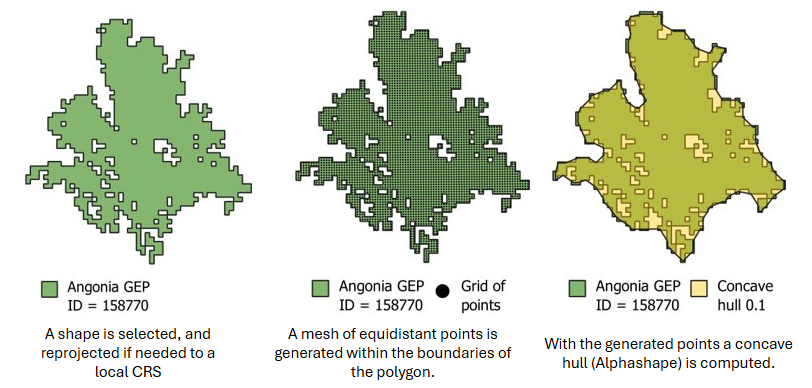

In [17]:
def beautyfing_cluster_single(gep_cluster, spacing=25, alpha=0.01):
    """
    Refines a single GeoPandas polygon (cluster) to create a visually smoother representation.

    Args:
        gep_cluster (GeoPandas GeoDataFrame): The input cluster polygon.
        spacing (float, optional): The spacing between grid points used for alpha shape creation. Defaults to 25.
        alpha (float, optional): The alpha parameter for the alpha shape algorithm, controlling the level of simplification. Defaults to 0.01.

    Returns:
        GeoPandas GeoDataFrame: A new GeoDataFrame containing the refined polygon as a single geometry.

    Exceptions:
         If the original cluster has a minimum width or height less than or equal to 105 meters, its geometry will not be processed.
    """
        
    minx, miny, maxx, maxy =gep_cluster.total_bounds
    
    gep_cluster_no_index = gep_cluster.reset_index()

    min_width = maxx - minx
    min_height = maxy - miny
    
    if min_width <= 105 or min_height <= 105:
        # Copy all columns except index to alphashape_gpd_new
        alphashape_gpd_new = gep_cluster.iloc[:, 0:]  # Select all rows and columns from 1 onwards (excluding index)
        alphashape_gpd_new.crs = gep_cluster.crs  # Copy CRS information
        
        return alphashape_gpd_new


    x_points = np.arange(minx, maxx, spacing)
    y_points = np.arange(miny, maxy, spacing)
    grid_points = np.array([Point(x, y) for x in x_points for y in y_points])
    
    list_points = []
    for points_par in grid_points:
        list_points.append(Point(points_par))
    
    grid_points_gpd=gpd.GeoDataFrame(geometry=grid_points, crs=gep_cluster.crs)
    
    points_in_polygons=gpd.clip(grid_points_gpd, gep_cluster)
    
    points_in_polygons_list = points_in_polygons.geometry.to_list()
    
    puntos_en_poligono = []
    for puntos in points_in_polygons_list:
        puntos_en_poligono.append([puntos.x, puntos.y])
    
    concave_hull = alphashape.alphashape(puntos_en_poligono, alpha=alpha)
    
    alphashape_gpd = gpd.GeoDataFrame(geometry=[concave_hull], crs=gep_cluster.crs)

    return alphashape_gpd

In [18]:
def beautyfing_clusters(gep_clusters, distance, alpha, crs):

    """
    Iterates a collection of GeoPandas polygons (clusters) to create visually smoother representations.

    Args:
        gep_clusters (GeoPandas GeoDataFrame): The input GeoDataFrame containing cluster polygons.
        distance (float): The spacing between grid points used for alpha shape creation in each cluster.
        alpha (float): The alpha parameter for the alpha shape algorithm, controlling the level of simplification in each cluster.
        crs (str): The target Coordinate Reference System (CRS) for the output GeoDataFrame.

    Returns:
        GeoPandas GeoDataFrame: A new GeoDataFrame containing refined cluster polygons as individual geometries.

    """

    gep_clusters_crs = gep_clusters.to_crs(crs)
    
    new_GEP_Clusters = gpd.GeoDataFrame(geometry=[], crs=gep_clusters_crs.crs)

    for index, row in gep_clusters_crs.iterrows():

        single_gpd = gpd.GeoDataFrame([row], columns=row.index)
        single_gpd.crs = gep_clusters_crs.crs
        
        new_alpha = beautyfing_cluster_single(single_gpd, distance, alpha)
    
        new_GEP_Clusters = pd.concat([new_GEP_Clusters, new_alpha])

    output_partial = new_GEP_Clusters.dissolve()

    output_final = output_partial.explode(index_parts=False).to_crs({ 'init': 'epsg:4326'})

    output_final['PLACEHOLDE']=1

    return output_final